## Visa

US Business sector has long facing high demand of human resources in various skillsets. 

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis, under visa such as H1B, H2B.

In FY 2016, the immigration office processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

## Objective
The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. The objective is to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 

## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent of the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied


## Question identification
* This is a binary classification to predict whether an applicants will be grant the visa (1) or not (0)

* percesion-recall trade off: In this task, we wish to have an 'even' distribution towards the trade off since skew to either side will require a human review in detail.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,precision_recall_curve,accuracy_score,recall_score,precision_score

#For modelling
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,StackingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [4]:
#check duplicate/null
df.isnull().any()
df.duplicated().any()

False

In [5]:
#check datatype
df.info()
#Many are object type, can be transfer as category
col = df.select_dtypes(['object']).columns
for c in col:
    df[c] = df[c].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [6]:
#check data descibtion, including category cols 
df.describe(include=['category','int64','float64']).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
case_id,25480,25480,EZYV01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
continent,25480,6,Asia,16861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_of_employee,25480,4,Bachelor's,10234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_job_experience,25480,2,Y,14802,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requires_job_training,25480,2,N,22525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no_of_employees,25480.0,NaN,NaN,NaN,5667.04321,22877.928848,-26.0,1022.0,2109.0,3504.0,602069.0
yr_of_estab,25480.0,NaN,NaN,NaN,1979.409929,42.366929,1800.0,1976.0,1997.0,2005.0,2016.0
region_of_employment,25480,5,Northeast,7195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prevailing_wage,25480.0,NaN,NaN,NaN,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27
unit_of_wage,25480,4,Year,22962,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- The employer's organization has an average of 5,667 employees, with a median of 2,109. The distribution is right-skewed with several positive outliers. The presence of a negative minimum value suggests an invalid data point.
- The dataset includes companies established between 1800 and 2016.
- The average prevailing wage for occupations in the United States is $74,455, while the median is $70,308. This indicates a slight right-skewness in the data. The minimum value of $2,136.7 appears to be an invalid data point. Further analysis should consider the unit of wage to gain more insight.
- The case ID attribute can be dropped as it is a unique identifier without any relevance to the visa status.
- The database contains 6 continents, with a majority of applicants from Asia.
- There are 4 levels of education, with a Bachelor's degree being the highest for most applicants.
- Most applicants do not require additional job training for their intended occupation in the US.
- There are 5 regions in the US with a shortage of human resources, with the highest shortage in the NorthEast region.
- There are 4 units of wages, with "yearly" being the most common. Further analysis should consider studying the prevailing wage and unit of wage together for better insights.
- Most occupations experiencing employee shortages are full-time positions.
- The attribute of interest is the case status, which needs to be predicted by the ML model. According to the dataset, 66.7% of all applicants have a certified visa status, while only 33.2% have a denied visa status.

In [7]:
#we don't require case id
df.drop(['case_id'],axis = 1, inplace = True)

## Exploratory Data Analysis (EDA)

### Univariate analysis

In [8]:
def hist_box_drawer(data,feature,figsize = (18,7), kde = False,bins = None):
    """
    data:dataframe
    feature:column to be visulize
    kde:whether to show kde curve
    bins: bins of histogram,default None
    """

    fig,[ax1,ax2] = plt.subplots(
        nrows =2,
        sharex = True,
        gridspec_kw = {'height_ratios':(.75,.25)},
        figsize = figsize
    )
    sns.boxplot(data=data,x = feature,ax = ax1,showmeans = True)
    sns.histplot(data = data,x = feature,ax = ax2,kde = kde,bins = bins) if bins else sns.histplot(data = data,x = feature,ax = ax2,kde = kde)
    #adding support line
    ax2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )
    ax2.axvline(
        data[feature].median(), color="red", linestyle="-"
    )
    


In [9]:
def draw_bars(data,feature,perc = False, n = None):
    """
    data = dataframe
    featrue = feature to be visulize
    perc = True if show percentage , False show count
    n: displays the top n category levels (default is None, i.e., display all levels)
    """
    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize = (count + 1,5))
    else:
        plt.figure(figsize = (n+1,5))
    plt.xticks(rotation = 90,fontsize =15)
    ax = sns.countplot(data = data,x = feature,
                       palette = 'Paired',
                       order = data[feature].value_counts().index[:n].sort_values(ascending = False))
    for p in ax.patches:
        if perc == True:
            label = f"{100*p.get_height()/total:.1f}%"
        else:
            label = p.get_height()
        x = p.get_x() + p.get_width() /2
        y = p.get_height()
        ax.annotate(
            label,
            (x,y),
            ha = 'center',
            va = 'center',
            size = 12,
            xytext=(0, 5),
            textcoords="offset points"
            
            
        )
    
    
    

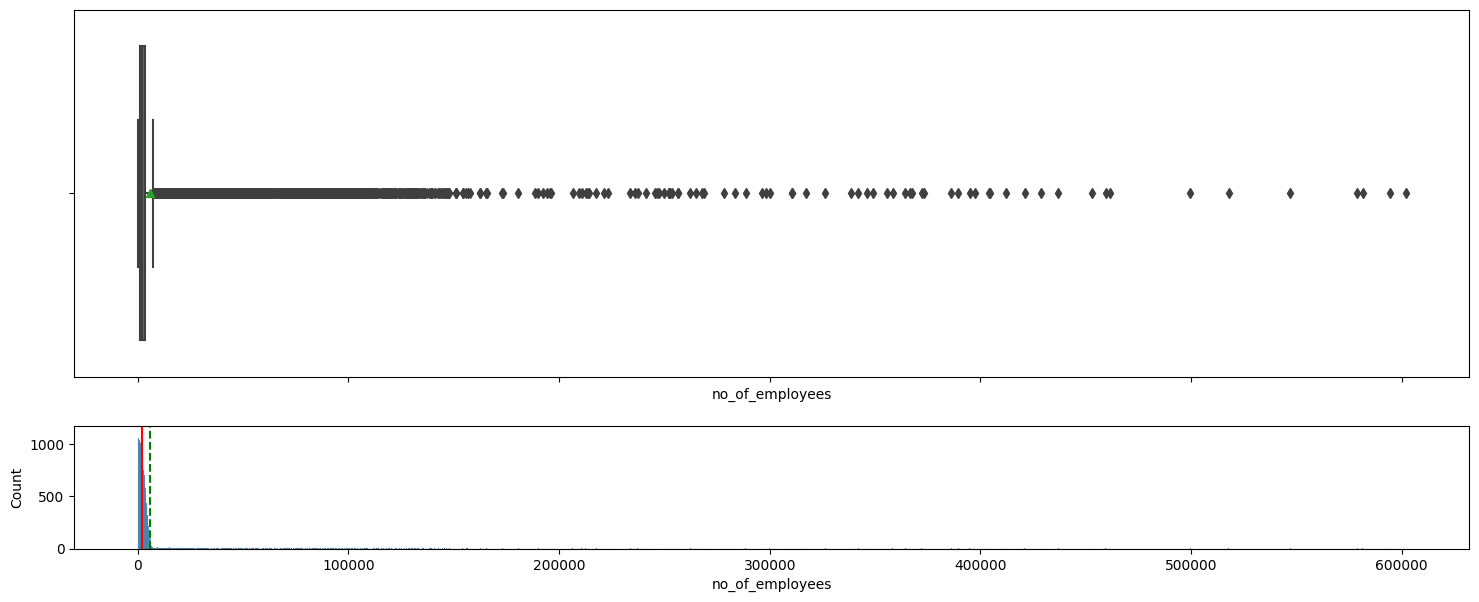

In [10]:
hist_box_drawer(df, "no_of_employees")
#The plot seems suggest we have company with less than 0 employees

In [11]:
#From eariler, we see there are company with 0 or negative staff, these can be remove
df = df.drop(df[df['no_of_employees']<= 0].index).reset_index(drop = True)

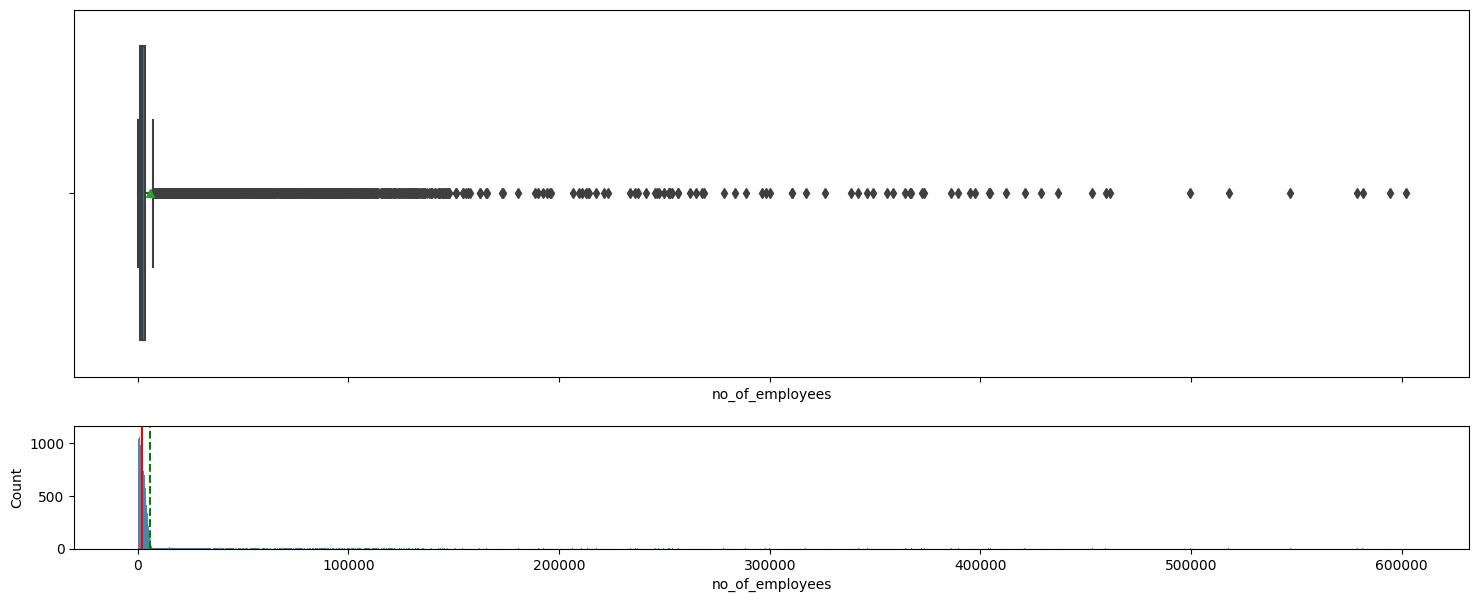

In [12]:
hist_box_drawer(df, "no_of_employees")

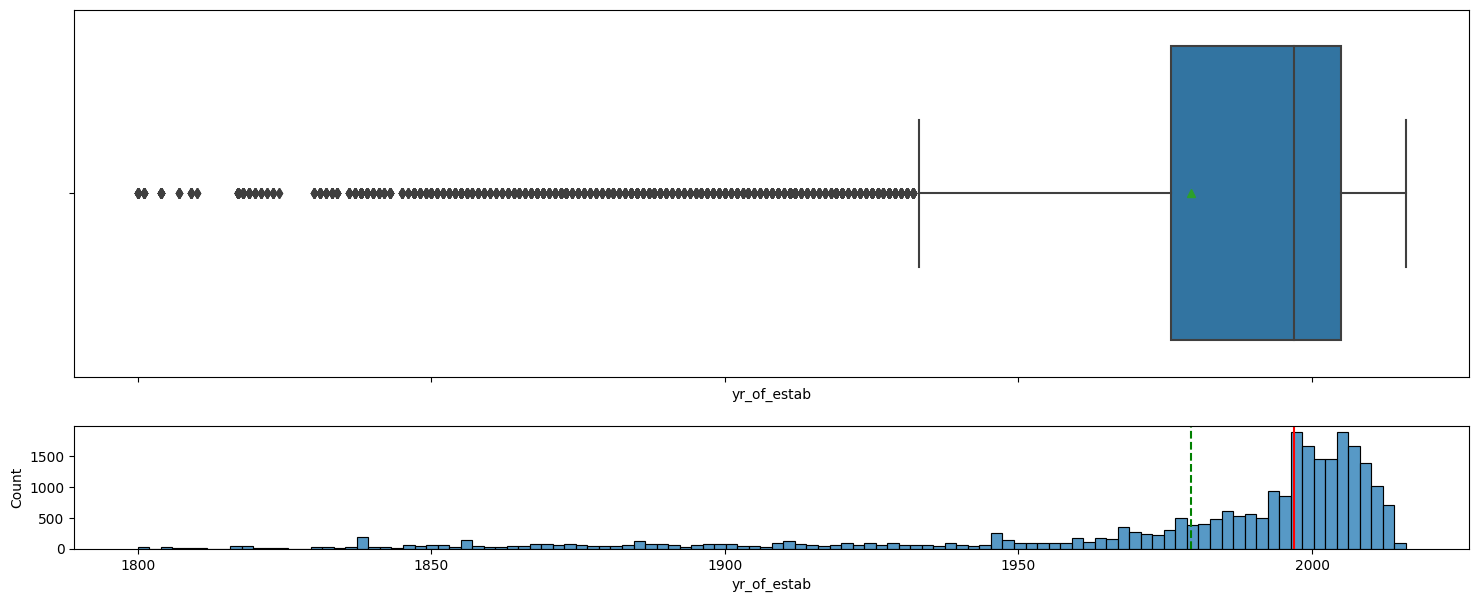

In [13]:
#Observations on year_of_establishment
hist_box_drawer(df, "yr_of_estab")

* We can see a left skew distribution, suggesting most sponser are establish around 1980

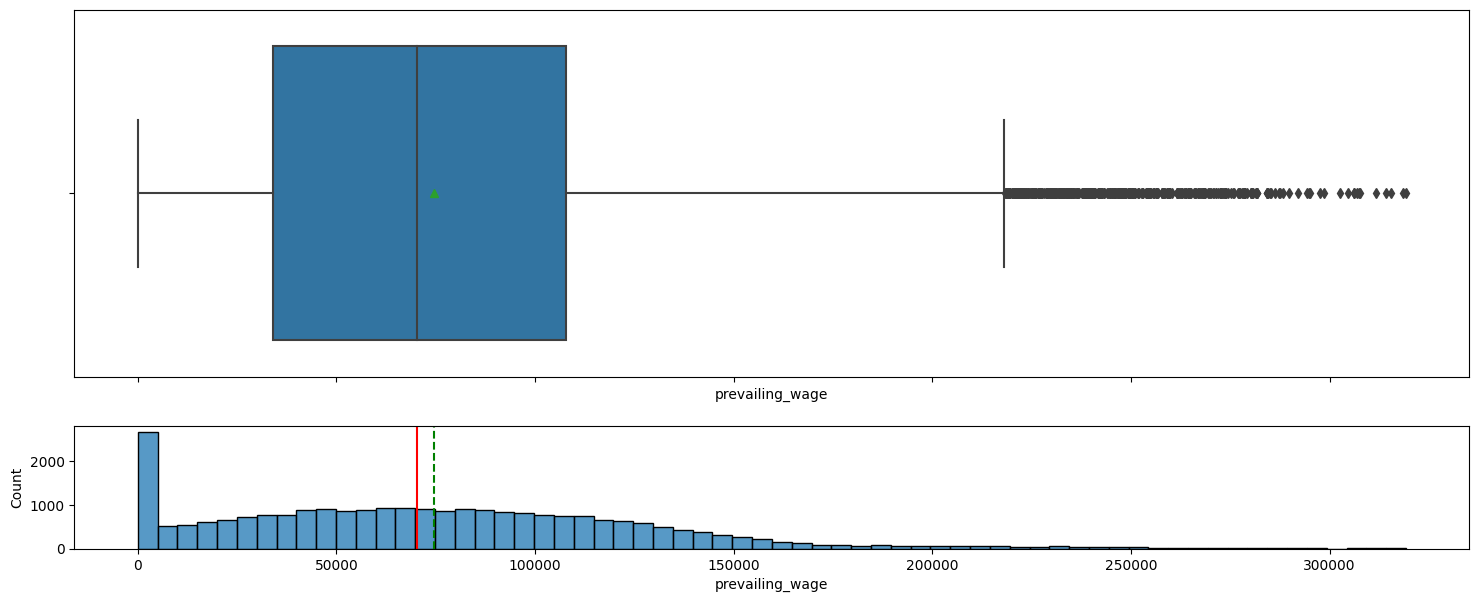

In [14]:
#the data have wage in both year,week,month and hours, making below trend no compareable as they are in different time scale
hist_box_drawer(df, "prevailing_wage")

- The average and median annual salary is approx. USD 70,000 which seems accurate back FY 2016
- The trend appears correct with outliers in the higher income bracket between USD 200,000 to USD 300,000
- There are several very low salaries(next to 0)as well, which appears incorrect and requires further investigation

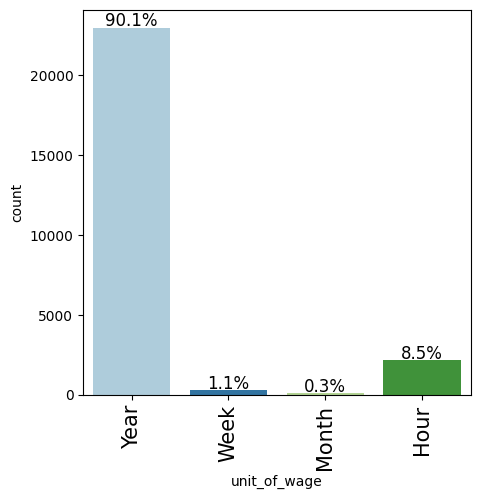

In [15]:
draw_bars(data = df,feature = 'unit_of_wage', perc = True)

- Almost 90% of all entries are with unit_of_wage as yearly and only 8.5% entries as hourly. Negligible entries are on a monthly and weekly basis (which requires further investigation)

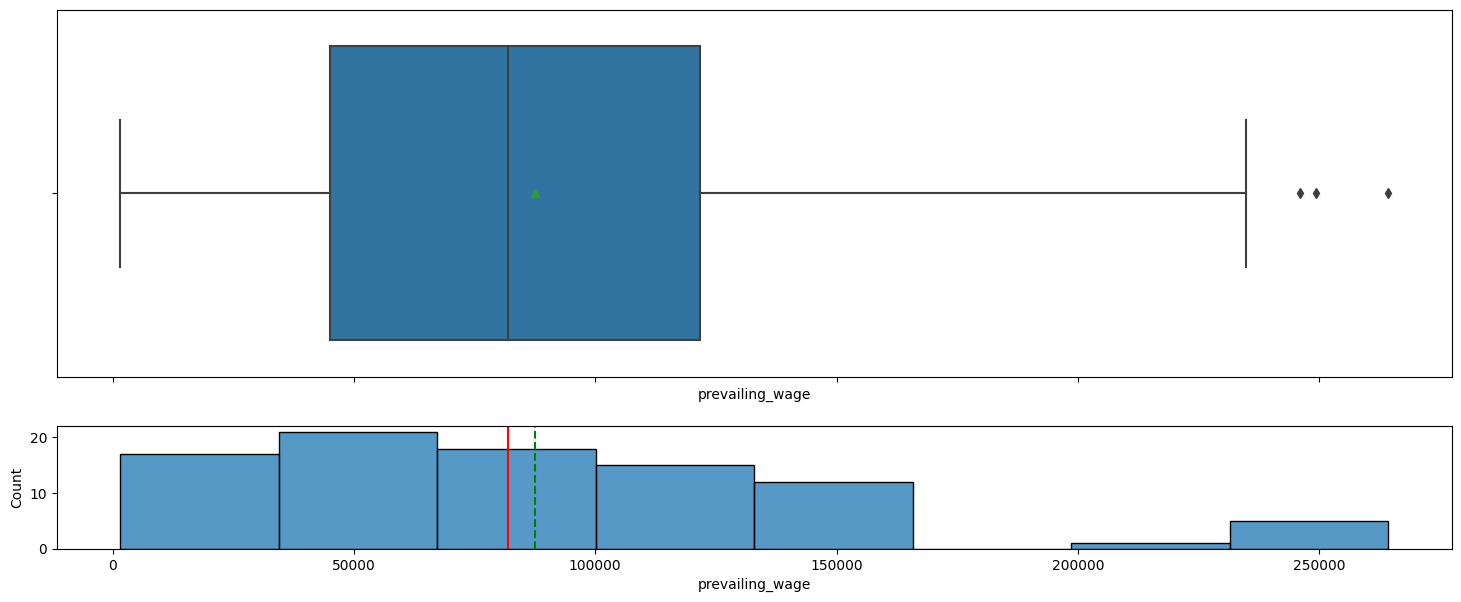

In [16]:
#Observations specifically on data where unit_of_wage is weekly or monthly
hist_box_drawer(df[(df["unit_of_wage"]=="Month")], "prevailing_wage")

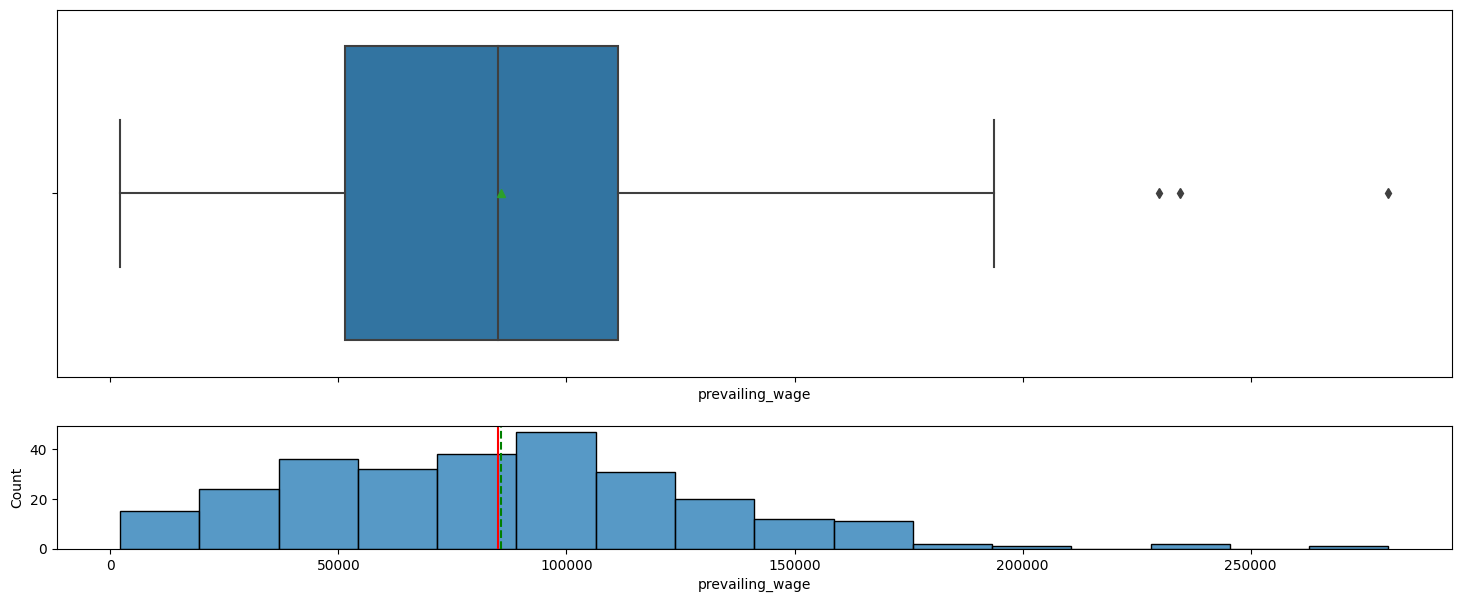

In [17]:
#Observations specifically on data where unit_of_wage is weekly or monthly
hist_box_drawer(df[(df["unit_of_wage"]=="Week")], "prevailing_wage")

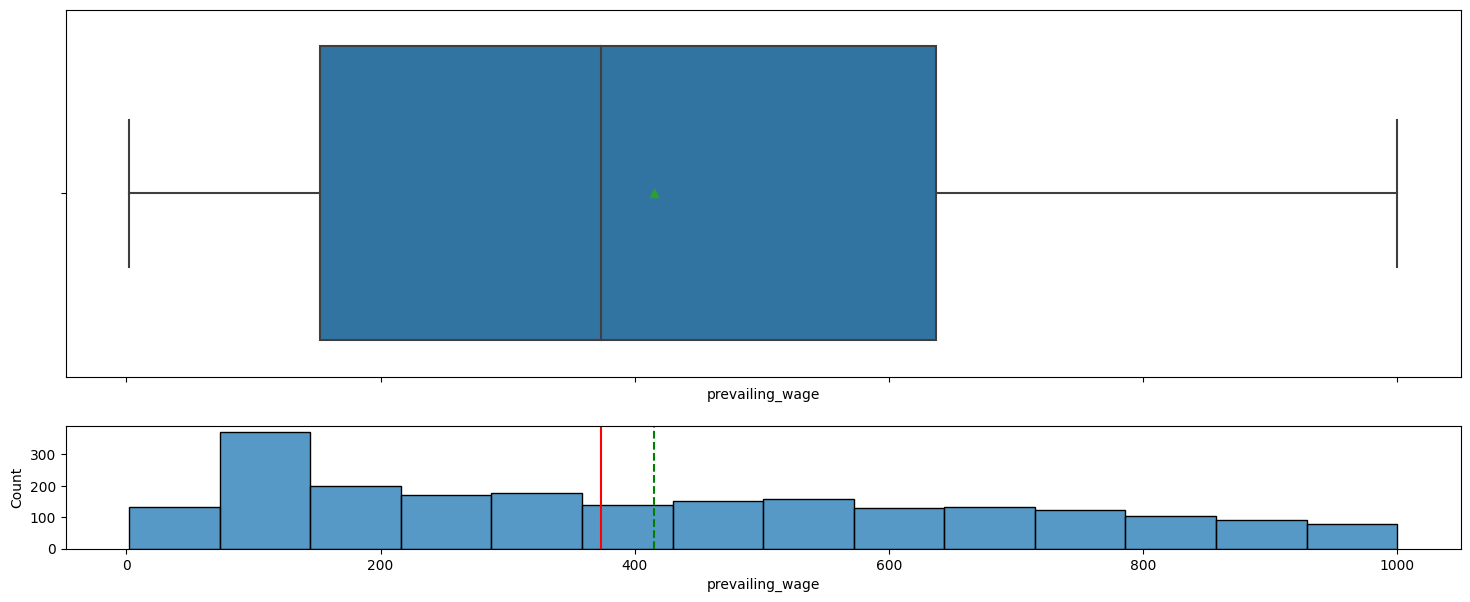

In [18]:
#Observations specifically on data where unit_of_wage is hourly
hist_box_drawer(df[(df["unit_of_wage"]=="Hour")], "prevailing_wage")

- From above, we can infer that prevailing_wages is likely already a yearly salary, since both medium and mean are relatively high, where unit_of_wage is either weekly or monthly.

In [19]:
df.loc[df["unit_of_wage"]=="Hour", "prevailing_wage"] = \
df.loc[df["unit_of_wage"]=="Hour", "prevailing_wage"]*52
# assuming 52 paid weeks per year

In [20]:
df["unit_of_wage"] = df["unit_of_wage"].astype('object')
df.loc[df["unit_of_wage"]=="Hour", "unit_of_wage"] = "Hourly"
df.loc[df["unit_of_wage"]=="Week", "unit_of_wage"] = "Not_Hourly"
df.loc[df["unit_of_wage"]=="Month", "unit_of_wage"] = "Not_Hourly"
df.loc[df["unit_of_wage"]=="Year", "unit_of_wage"] = "Not_Hourly"
df["unit_of_wage"] = df["unit_of_wage"].astype('category')

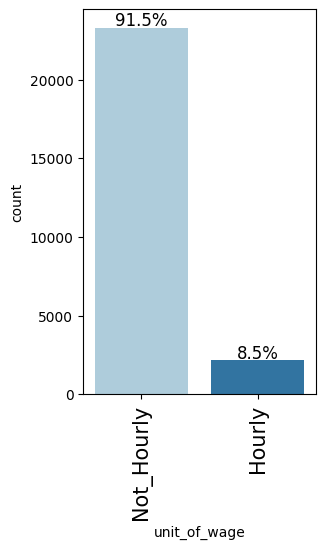

In [21]:
draw_bars(df, "unit_of_wage", perc=True)

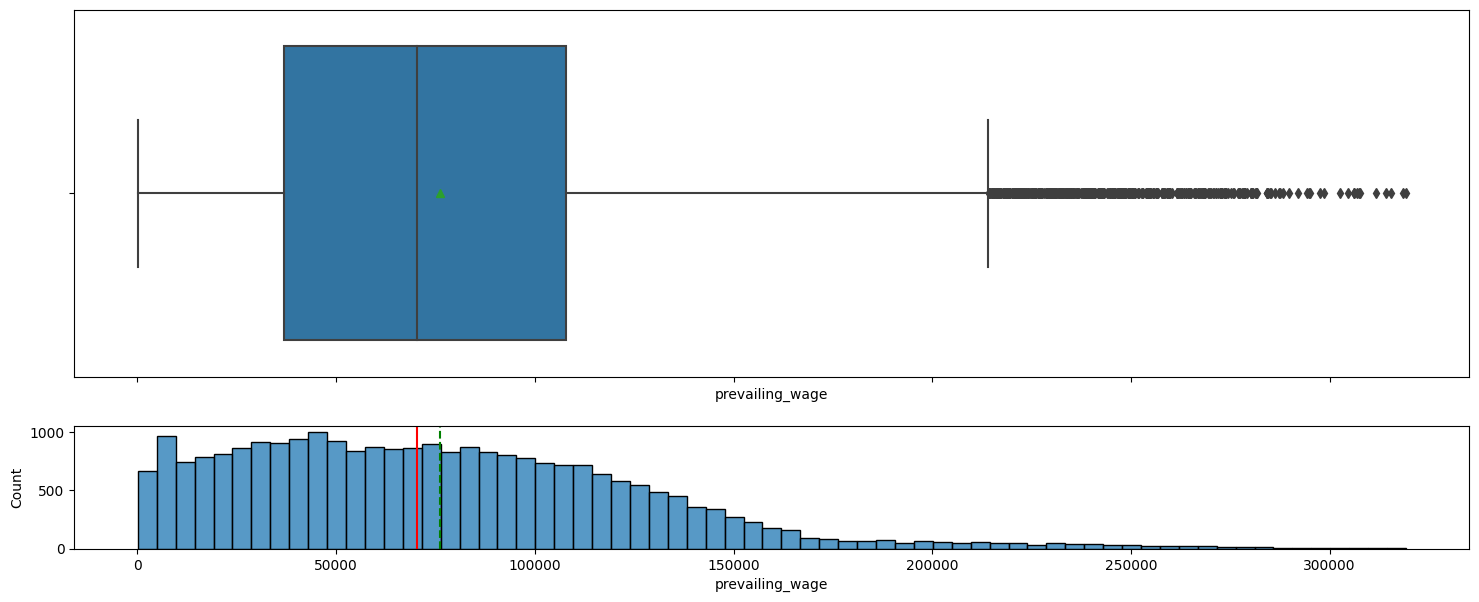

In [22]:
hist_box_drawer(df, "prevailing_wage")

- We still have several lower and upper end outlier in annual_prevailing_wages which requires further investigation

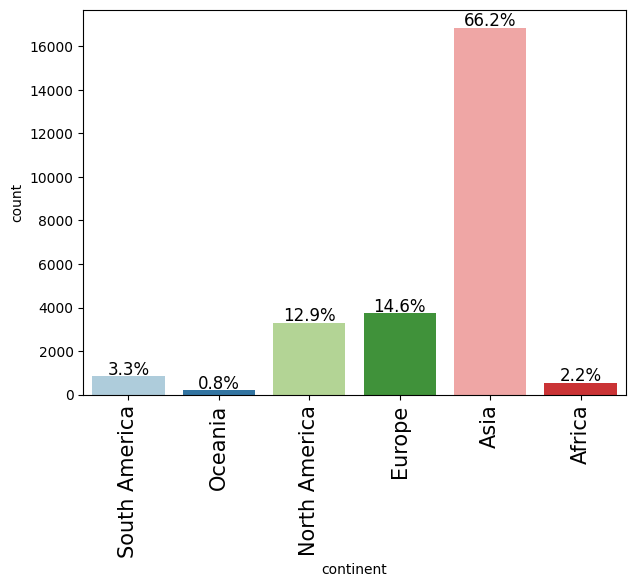

In [23]:
#Observations on continent
draw_bars(df, "continent", perc=True)

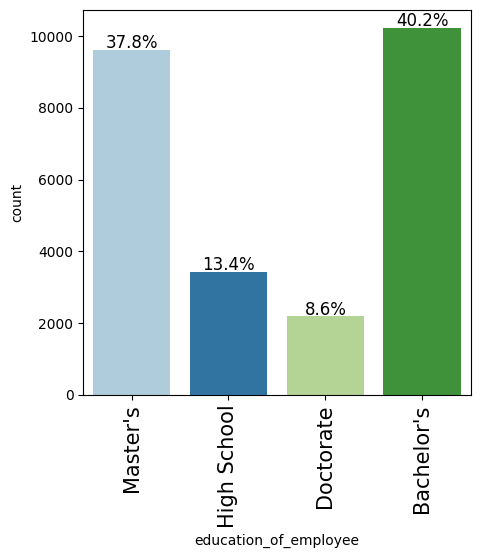

In [24]:
#Observations on education
draw_bars(df, "education_of_employee", perc=True)

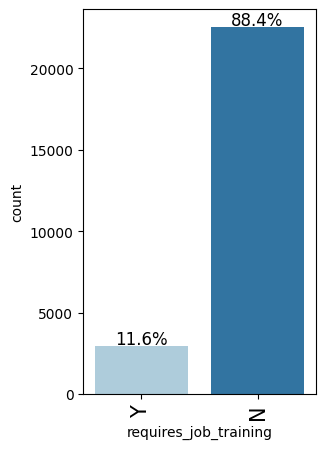

In [25]:
#Observations on requires_training
draw_bars(df, "requires_job_training", perc=True)

- Majority of employees (>50%) are from Asia 
- In most position, company prefer support staff with experience(No training require)
- 78% of total applicant has at lesat a higher-education degree, under or post grad


From above, we have provide a persona of a potencial success applicant

An Asian background applicant with a Bachelor degree and few year of experience in the sector, and annual income around 70,000 USD

### Bivariate analysis and data preprocessing 

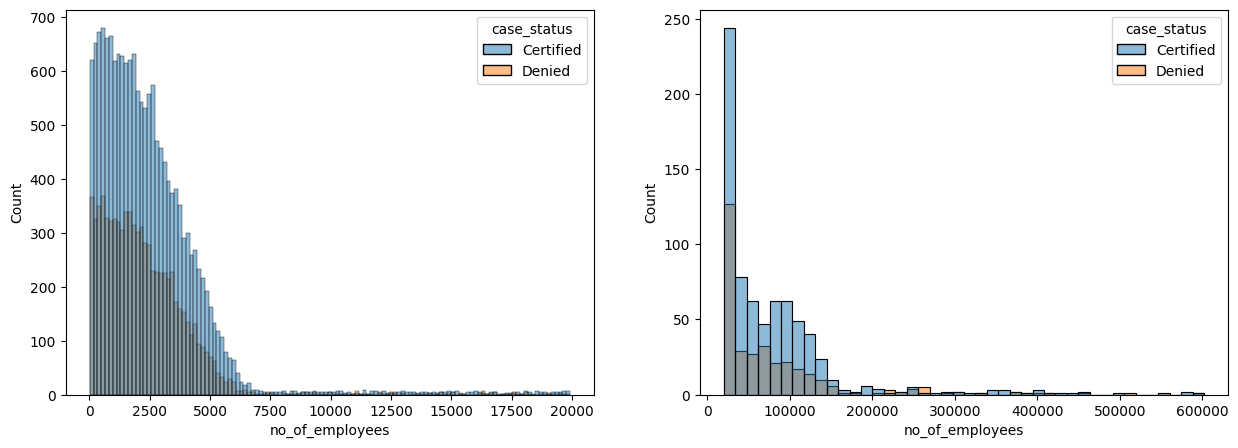

In [26]:
#number of employees and case status
fig,ax=plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=df[df["no_of_employees"]<20000], x="no_of_employees", hue="case_status", ax=ax[0]);
sns.histplot(data=df[df["no_of_employees"]>20000], x="no_of_employees", hue="case_status", ax=ax[1]);

- There are more than twice as many certified cases compared to denied cases, regardless of the number of employees in the employers' organizations.

- The attribute contains a large number of outliers, which may need additional handling. However, since the ML model used is based on decision trees that automatically optimize and split the data, we can choose to group the continuous data into three bins for faster model building. This decision is based on the exploratory data analysis (EDA), which did not reveal a specific relationship between case certification and the number of employees in an organization.

In [27]:
#Cut number of employees into categories
df['no_of_employees'] = pd.cut(df['no_of_employees'],
                               [0,2500,8000,np.inf],
                               labels = ['Small_Size(<2500)',
                                         'Mid_Sized(2500-8000)',
                                         'Large_Sized(>8000)'])
df['no_of_employees'] =df['no_of_employees'].astype('category')

In [28]:
count = df['no_of_employees'].nunique()
sorter = df['case_status'].value_counts().index[1]
tab_view = pd.crosstab(df['no_of_employees'], df['case_status'], margins=True).sort_values(
        by=sorter, ascending=False
    )
print(tab_view)
print("-" * 120)
tab_norm = pd.crosstab(df['no_of_employees'], df['case_status'], normalize = 'index').sort_values(
        by=sorter, ascending=False
    )



case_status           Certified  Denied    All
no_of_employees                               
All                       17001    8446  25447
Small_Size(<2500)          9674    5084  14758
Mid_Sized(2500-8000)       6289    2880   9169
Large_Sized(>8000)         1038     482   1520
------------------------------------------------------------------------------------------------------------------------


<Axes: xlabel='no_of_employees'>

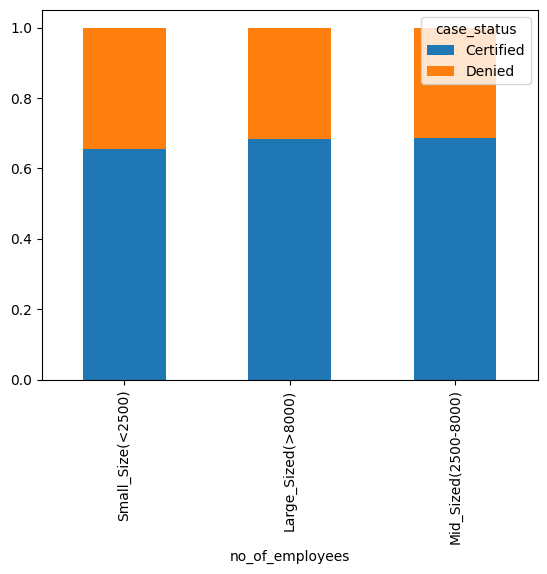

In [29]:
tab_norm.plot(kind = 'bar',stacked = True)

In [30]:
def draw_stackbar(data,predictor,target):
    """
    data: dataframe
    predictor: independent variable
    target: target variable
    """
    sorter = data[target].value_counts().index[-1]
    tab_view = pd.crosstab(data[predictor], df[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab_view)
    print("-" * 120)
    tab_norm = pd.crosstab(data[predictor], df[target], normalize = 'index').sort_values(
            by=sorter, ascending=False
    )
    tab_norm.plot(kind = 'bar',stacked = True)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    

case_status           Certified  Denied    All
no_of_employees                               
All                       17001    8446  25447
Small_Size(<2500)          9674    5084  14758
Mid_Sized(2500-8000)       6289    2880   9169
Large_Sized(>8000)         1038     482   1520
------------------------------------------------------------------------------------------------------------------------


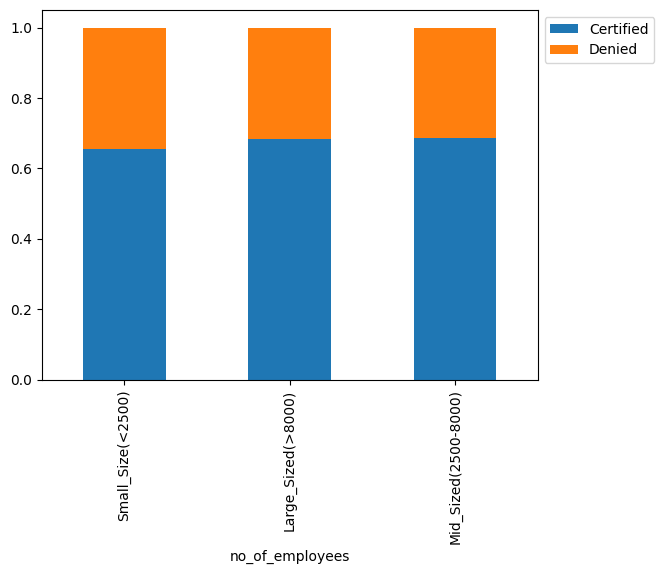

In [31]:
draw_stackbar(df, "no_of_employees", "case_status")

- Overall the vias got more approval rate of 3:1 ratio, regardless of the company size

case_status   Certified  Denied    All
unit_of_wage                          
All               17001    8446  25447
Not_Hourly        16254    7040  23294
Hourly              747    1406   2153
------------------------------------------------------------------------------------------------------------------------


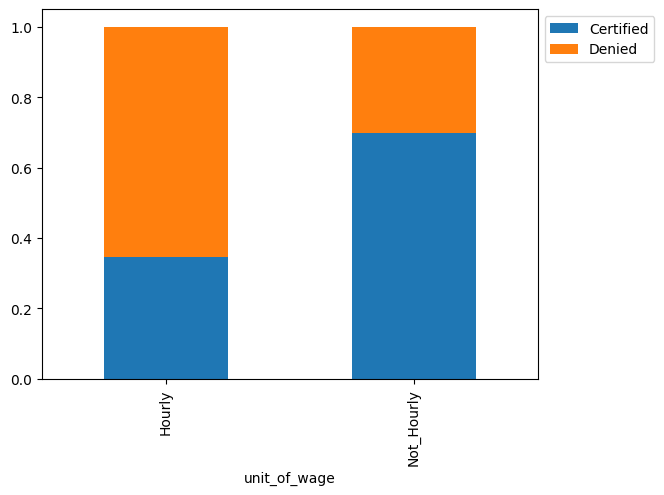

In [32]:
draw_stackbar(df, "unit_of_wage", "case_status")

- Staff got paid by hourly rate are more likely to be reject

case_status    Certified  Denied    All
continent                              
All                17001    8446  25447
Asia               11001    5839  16840
North America       2037    1250   3287
Europe              2953     774   3727
South America        492     359    851
Africa               396     154    550
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


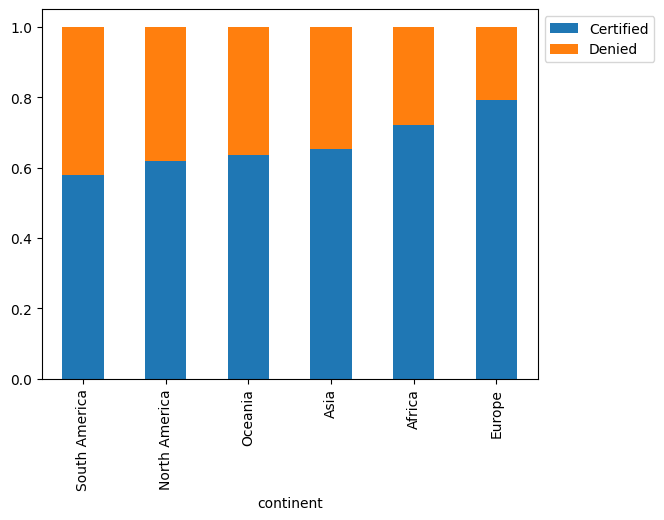

In [33]:
#continent and case status
draw_stackbar(df, "continent", "case_status")

case_status            Certified  Denied    All
education_of_employee                          
All                        17001    8446  25447
Bachelor's                  6362    3858  10220
High School                 1164    2252   3416
Master's                    7565    2057   9622
Doctorate                   1910     279   2189
------------------------------------------------------------------------------------------------------------------------


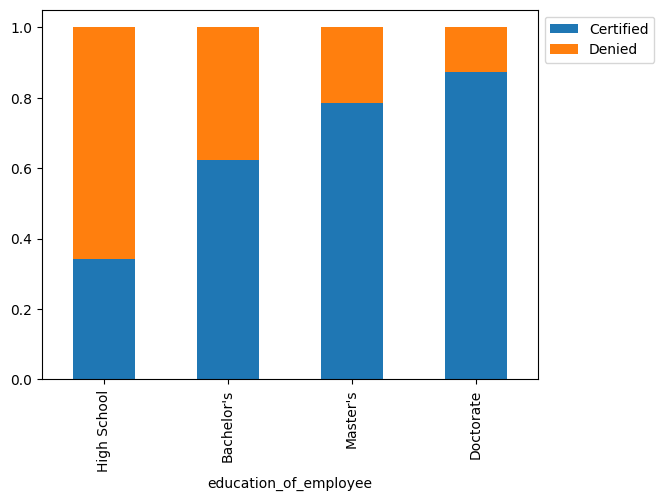

In [34]:
#education and case status
draw_stackbar(df, "education_of_employee", "case_status")

case_status         Certified  Denied    All
has_job_experience                          
All                     17001    8446  25447
N                        5986    4675  10661
Y                       11015    3771  14786
------------------------------------------------------------------------------------------------------------------------


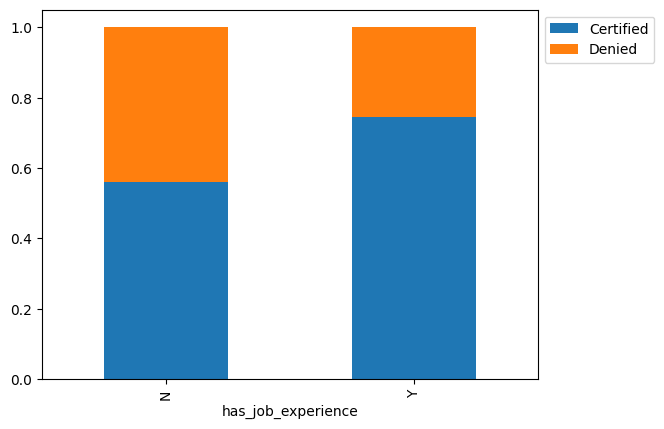

In [35]:
#job_experience and case status
draw_stackbar(df, "has_job_experience", "case_status")

- Irrespective of the continent the employee is from, more cases are certified than denied
- The trend observed w.r.t % certification for continents is Europe > Africa > Asia > Oceania > North America & South America 

- Level of education contributed significantlly to the success rate where has experience or not also affecting the success rate but less important

### EDA Summary

- The number of certified cases is more than twice the number of denied cases, regardless of the number of employees in the employer's organization or the year of establishment. These attributes are not expected to influence case statuses.
  - Both attributes exhibit skewness, with the number of employees skewed to the right and the year of establishment skewed to the left.
  - Based on the exploratory data analysis (EDA), approximately 58% of cases were for smaller organizations (with fewer than 2500 employees), and 61% of cases were for employers established after 1990.
  
  
- When the unit of wage is hourly, only 35% of cases are certified. However, when the unit of wage is not hourly (weekly, monthly, or yearly), 70% of cases are certified. This suggests that the unit of wage is an important attribute that can influence case statuses.
  - From the EDA, it is observed that only 8.5% of cases were associated with hourly wages, while the remaining 91.5% were associated with non-hourly wages (weekly, monthly, or yearly).
  
  
- The majority of cases come from applicants in Asia (66%), followed by Europe (15%), North America (13%), and South America (3%). However, the certification rate is highest for cases from Europe (80%), followed by Africa (72%), and Asia (65%). The lowest certification rates are observed for South America and North America (around 60%). The continent of origin does not significantly affect the number of cases certified.
  

- Most applicants have a bachelor's degree (40%) or a master's degree (37.87%). A small percentage have only a high school certification (13.4%) or hold a doctorate degree (8.6%). However, the certification rate is highest for applicants with a doctorate degree (>86%), followed by a master's degree (>76%), and then a bachelor's degree (~62%). Cases with only a high school certification have a very low certification rate (<35%). This trend suggests that having a doctorate degree or only a high school certification greatly influences case certification.
  
  
- Based on the EDA, it is inferred that 58% of all applicants have prior job experience, while 42% do not. The certification rate is higher for applicants with prior job experience (75% of such cases) compared to those without prior job experience (~56% of such cases). Having prior job experience significantly contributes to a case being certified.
  
  
- The majority of cases do not require additional job training for the employees. This attribute does not have a significant impact on case statuses.
  
  
- The majority of applications are for the Northeast region (28.3%), followed by the South (27.5%), the West (25.8%), and the Midwest (16.9%). The Island region has the fewest applications (1.5%). However, the certification rates follow the trend of Midwest (75% of such cases), followed by the South (70% of such cases), and then the Northeast, West, and Island regions (60% of such cases). Being in the Midwest region is an important attribute positively contributing to a case being certified.
  
  
- The majority of jobs are full-time rather than part-time. This attribute does not have a significant impact on case statuses.

## Modelling

In [36]:
df["case_status"] = df["case_status"].apply(lambda x: 0 if x == "Denied" else 1)

In [37]:
#Separating features and the target column
X = df.drop("case_status", axis=1)
y = df["case_status"]

In [38]:
X = pd.get_dummies(X, drop_first=True)

In [39]:
#Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [40]:
X_train.shape, X_test.shape

((17812, 20), (7635, 20))

In [41]:
y.value_counts(1)

case_status
1    0.668094
0    0.331906
Name: proportion, dtype: float64

In [42]:
y_train.value_counts(1)

case_status
1    0.668089
0    0.331911
Name: proportion, dtype: float64

In [43]:
def model_performance(model,predictor,target):
     """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictor: independent variables
    target: dependent variable
    """
     pred = model.predict(predictor)

     acc = accuracy_score(target,pred)
     precision = precision_score(target,pred)
     recall = recall_score(target,pred)
     f1 = f1_score(target,pred)

     df_pred = pd.DataFrame(
          {
               'Accuracy' : acc,
               'Precision': precision,
               'Recall': recall,
               'f1_score':f1
          },index = [0]
     )
     cm = confusion_matrix(target, pred)
     fig, ax = plt.subplots(figsize=(8, 6))
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
     ax.set_xlabel('Predicted')
     ax.set_ylabel('Actual')
     ax.set_title('Confusion Matrix')
     ax.xaxis.set_ticklabels(['Negative', 'Positive'])
     ax.yaxis.set_ticklabels(['Negative', 'Positive'])

     plt.show()

     return df_pred

* We will be tring few type of model apart from tree model

In [44]:
models = [('AdaBoostClassifier',AdaBoostClassifier(random_state=1)),
         ("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")),
         ('BaggingClassifier',BaggingClassifier(random_state=1)),
         ('KNN',KNeighborsClassifier()),
          ('RandomForestClassifier',RandomForestClassifier(random_state=1)),
          ('DecisionTreeClassifier',DecisionTreeClassifier(random_state= 1))]


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []


print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring='f1_macro', cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print(f"{name}: {cv_result.mean():.5f}")


Cross-Validation Performance:

AdaBoostClassifier: 0.66989
Xgboost: 0.68292
BaggingClassifier: 0.65626
KNN: 0.49868
RandomForestClassifier: 0.66107
DecisionTreeClassifier: 0.62182


#We also want to know if oversampling can help improve the prediction performance

In [45]:
print(
    f"Before Oversampling, counts of label '1 (Failures)': {sum(y_train == 1)}")
print(
    f"Before Oversampling, counts of label '0 (No failures)': {sum(y_train == 0)} \n"
)



Before Oversampling, counts of label '1 (Failures)': 11900
Before Oversampling, counts of label '0 (No failures)': 5912 



In [46]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [47]:
print(
    f"After Oversampling, counts of label '1 (Failures)': {sum(y_train_over == 1)}")
print(
    f"After Oversampling, counts of label '0 (No failures)': {sum(y_train_over == 0)} \n"
)

After Oversampling, counts of label '1 (Failures)': 11900
After Oversampling, counts of label '0 (No failures)': 11900 



In [48]:
models_over = [('AdaBoostClassifier',AdaBoostClassifier(random_state=1)),
         ("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")),
         ('BaggingClassifier',BaggingClassifier(random_state=1)),
         ('KNN',KNeighborsClassifier()),
          ('RandomForestClassifier',RandomForestClassifier(random_state=1)),
          ('DecisionTreeClassifier',DecisionTreeClassifier(random_state= 1))]


results_over  = []  # Empty list to store all model's CV scores
names_over  = []  # Empty list to store name of the models
score_over  = []


print("\n" "Cross-Validation Performance With Oversample:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result_over = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring='f1_macro', cv=kfold
    )
    results_over.append(cv_result_over)
    names_over.append(name)
    print(f"{name}: {cv_result_over.mean():.5f}")


Cross-Validation Performance With Oversample:

AdaBoostClassifier: 0.78298
Xgboost: 0.78897
BaggingClassifier: 0.75627
KNN: 0.60068
RandomForestClassifier: 0.77394
DecisionTreeClassifier: 0.72844


Combine both normal and oversample result, AdaBoost,Xgboost and RandomForst are the top tier performer, we will continue using these 3 models

## AdaBoost

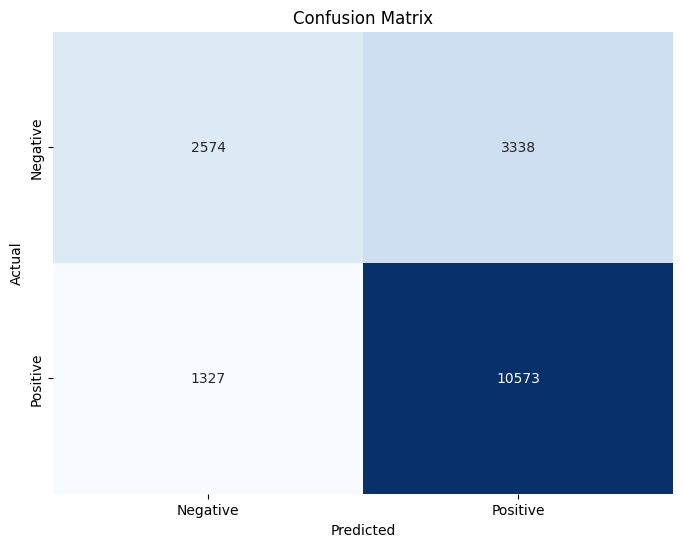

,Accuracy,Precision,Recall,f1_score
0,0.738098,0.760046,0.888487,0.819263


In [49]:
ada = AdaBoostClassifier(random_state=1)
ada.fit(X_train,y_train)
model_performance(ada,X_train,y_train)

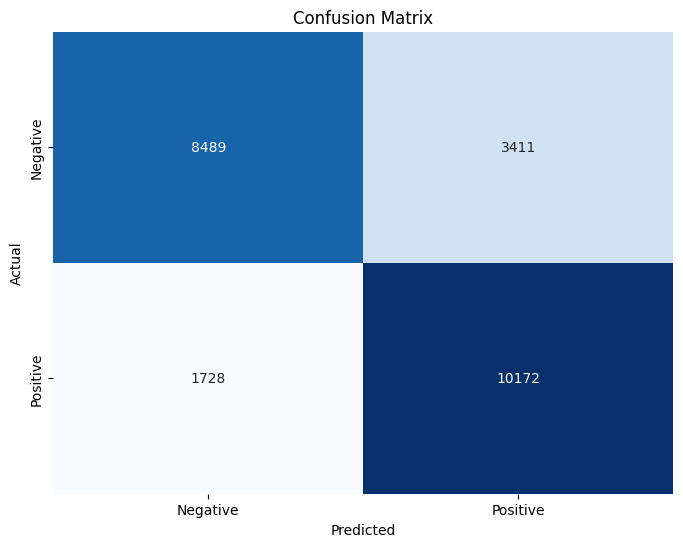

,Accuracy,Precision,Recall,f1_score
0,0.784076,0.748877,0.85479,0.798336


In [50]:
ada.fit(X_train_over,y_train_over)
model_performance(ada,X_train_over,y_train_over)

## XGBoost

[18:22:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric", "random_stage" } are not used.



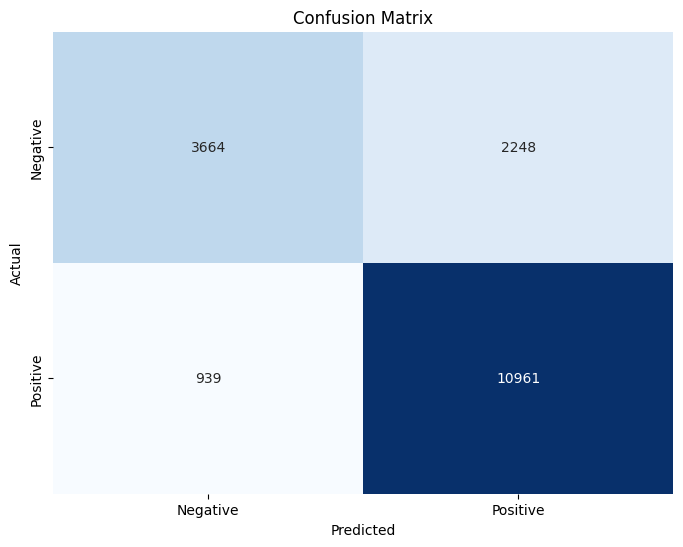

,Accuracy,Precision,Recall,f1_score
0,0.821076,0.829813,0.921092,0.873073


In [51]:
xgb =XGBClassifier(metric = 'logloss',random_stage = 1)
xgb.fit(X_train,y_train)
model_performance(xgb,X_train,y_train)

[18:22:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "metric", "random_stage" } are not used.



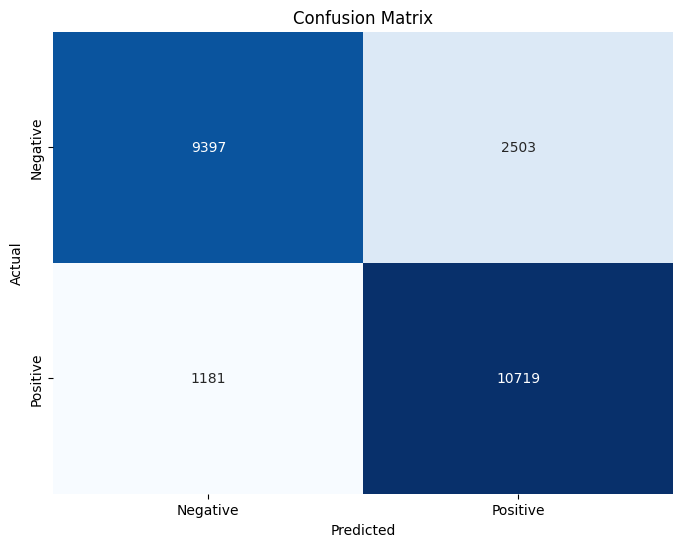

,Accuracy,Precision,Recall,f1_score
0,0.84521,0.810694,0.900756,0.853356


In [52]:
xgb.fit(X_train_over,y_train_over)
model_performance(xgb,X_train_over,y_train_over)

## Random Forest

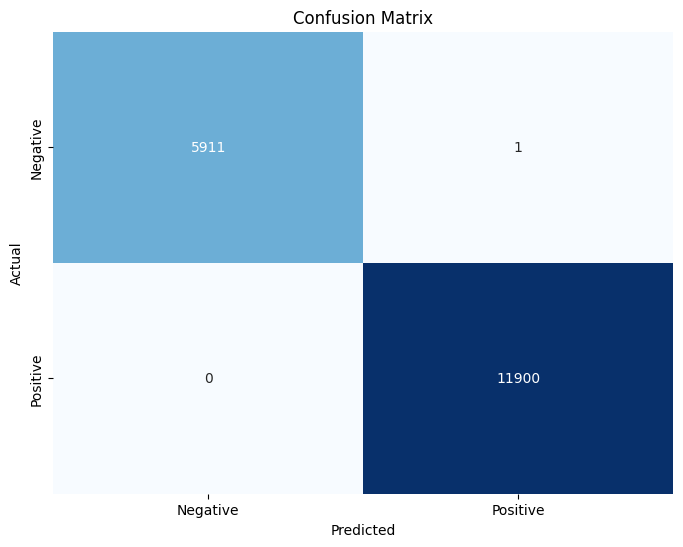

,Accuracy,Precision,Recall,f1_score
0,0.999944,0.999916,1.0,0.999958


In [53]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train,y_train)
model_performance(rf,X_train,y_train)

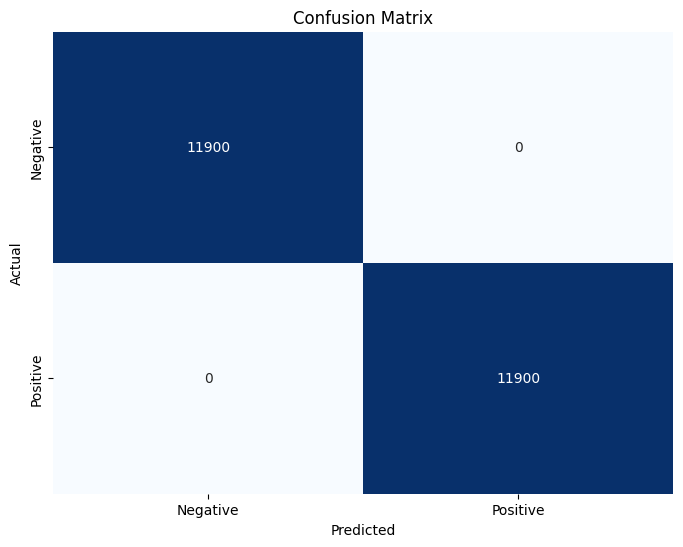

,Accuracy,Precision,Recall,f1_score
0,1.0,1.0,1.0,1.0


In [54]:
rf.fit(X_train_over,y_train_over)
model_performance(rf,X_train_over,y_train_over)

Randomforest shows overfitting in both normal and oversize dataset, Xgboost provided better F1 in both setting vs Adaboost. We will then finetune XGBoost only

In [55]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50,100],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1,0.35],
    "learning_rate":[0.05, 0.1,0.2,0.001],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}


# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring='f1_macro',cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [56]:
# Choose the type of classifier. 
xgb_tuned_over = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50,100],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1,0.35],
    "learning_rate":[0.05, 0.1,0.2,0.001],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}


# Run the grid search
grid_obj_over = GridSearchCV(xgb_tuned, parameters,scoring='f1_macro',cv=5)
grid_obj_over  = grid_obj_over .fit(X_train_over , y_train_over )

# Set the clf to the best combination of parameters
xgb_tuned_over  = grid_obj_over .best_estimator_

# Fit the best algorithm to the data.
xgb_tuned_over .fit(X_train_over , y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

0.8106378558071888


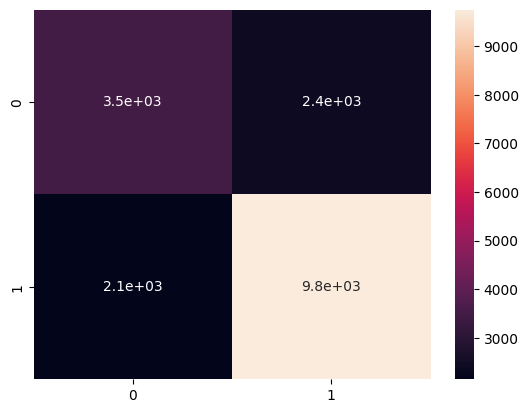

In [57]:
y_pred_tune = xgb_tuned.predict(X_train)
cm = confusion_matrix(y_train,y_pred_tune)
sns.heatmap(data = cm,annot = True)
print(f1_score(y_train,y_pred_tune))

0.8342554726966562


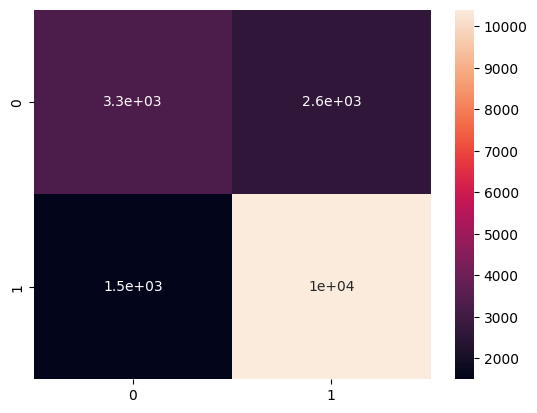

In [58]:
y_pred_tune_over = xgb_tuned_over.predict(X_train)
cm = confusion_matrix(y_train,y_pred_tune_over)
sns.heatmap(data = cm,annot =True)
print(f1_score(y_train,y_pred_tune_over))

Using STOME,we have driven a higher F1 score

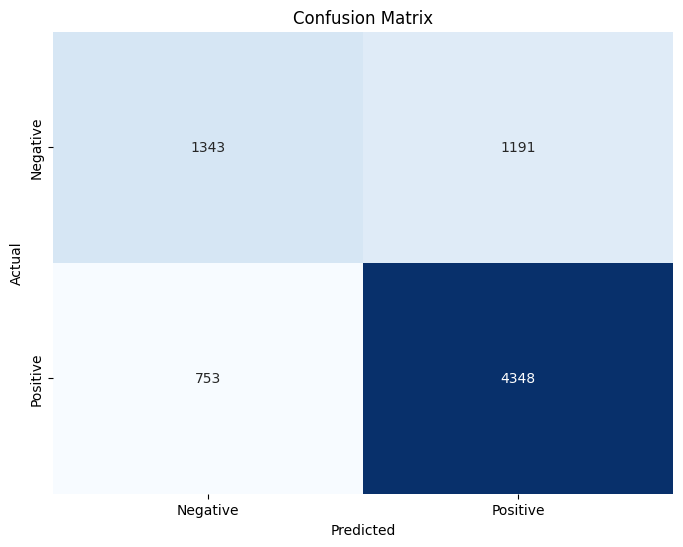

,Accuracy,Precision,Recall,f1_score
0,0.745383,0.784979,0.852382,0.817293


In [59]:
model_performance(xgb_tuned_over,X_test,y_test)

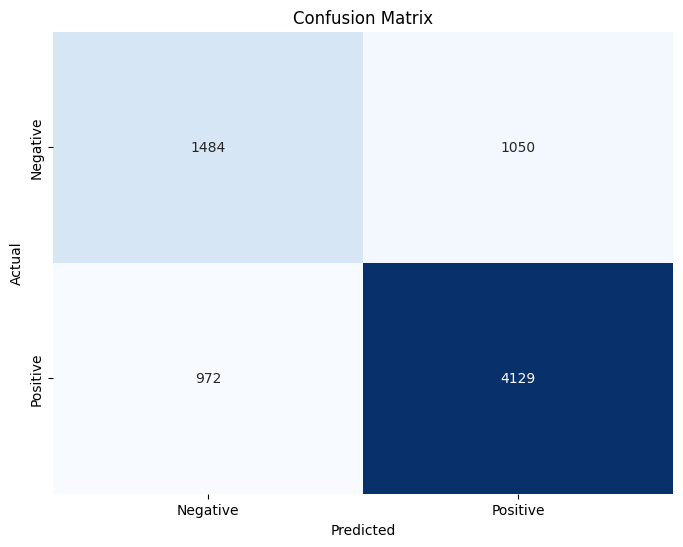

,Accuracy,Precision,Recall,f1_score
0,0.735167,0.797258,0.809449,0.803307


In [60]:
model_performance(xgb_tuned,X_test,y_test)

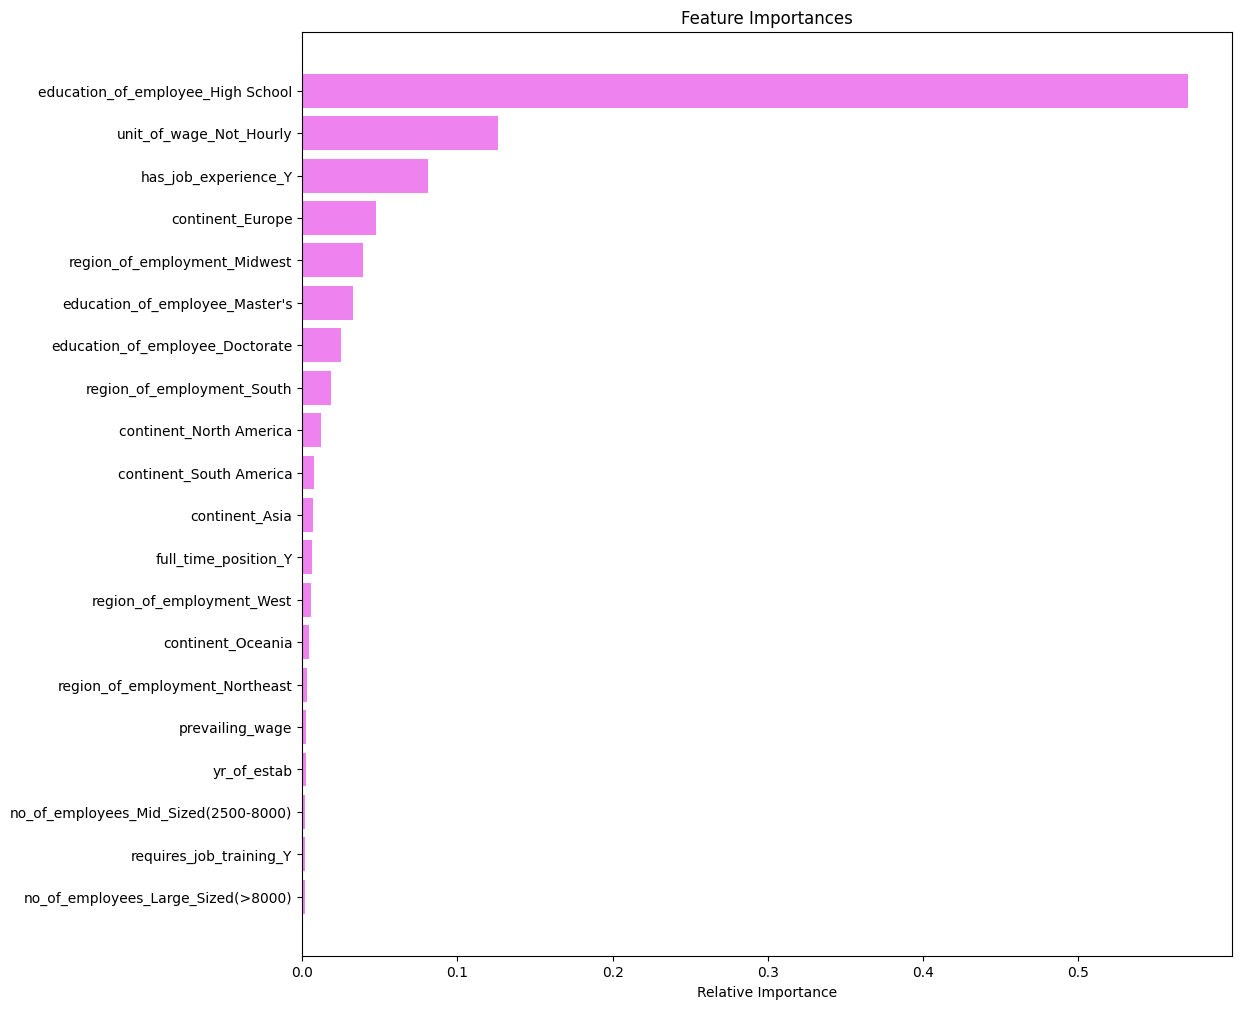

In [61]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

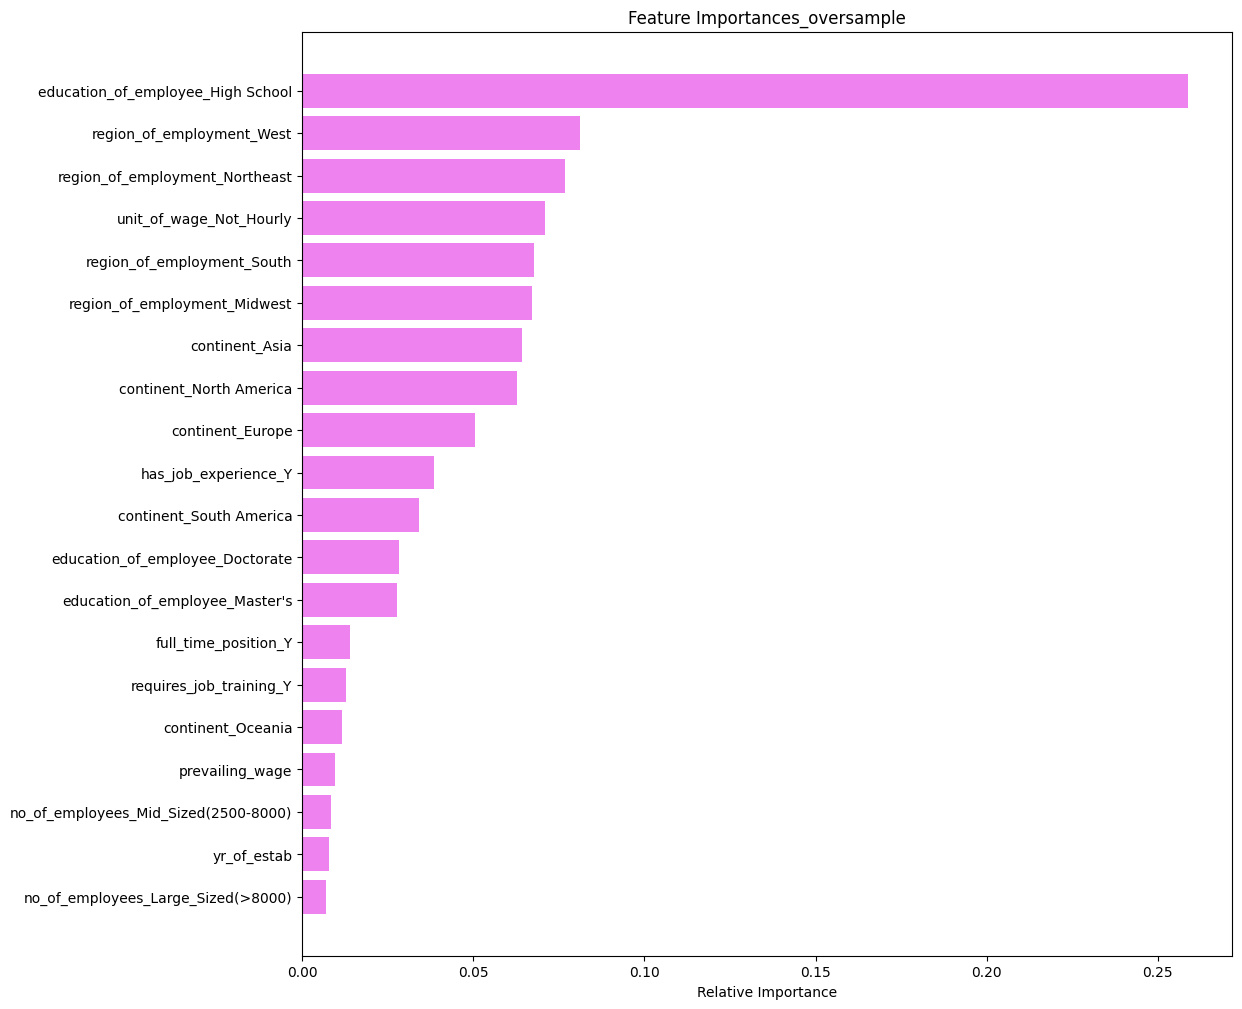

In [62]:
feature_names = X_train_over.columns
importances = xgb_tuned_over.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances_oversample')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- As for feature importance, the original data will give a better insight since it is not modified by oversampling algorithms.
- The findings from the tuned model is similar to what was observed post EDA
- Education of the employee was found to be the most important attribute having an influence on visa certifications, note that high school certificant that contribute the most. Other important attributes found were - if an employee has prior job experience, unit_of_wage, continent of the employee, & region of employment in the US.

## Project Insight and Recomendate action

- Based on the EDA & model, the following features were identified as important for visas getting certified than denied
     - (1) Education of employee ; an employee with only a high school certififcation has over 65% chance of visa getting denied in comparison to an employee with a doctorate degree with over a 85% chance of visa getting certified
     - (2) Unit of wage ; an employee with an hourly pay likewise has over 65% chance of visa getting denied in comparison to an employee with a non-hourly pay (week-ly, month-ly or year-ly) with over 70% chance of visa getting certified
     - (3) The continent the employee is from (e.g., if Europe, over 80% chance of visa getting certified), if the employee has prior job experience (over 75% chance of visa getting approved if an employee has prior work experience but 50% chance of visa getting denied if an employee has no work experience) are other important attributes
     - (4) Likewise, the region of the US the employment opportunity is in is also an important deciding factor with over 70% cases getting certified if the region is Midwest or South